In [17]:
from os import path, walk
from matplotlib import pyplot as plt
from matplotlib import patches
import random as rd
from tqdm import tqdm
import cv2 as cv
import numpy as np
import pandas as pd
from scipy import signal
from scipy import ndimage
import time

# custom lib
from inspect import getsourcefile
import os.path as path, sys
sys.path.insert(0, "..")
from alprLib.PlateBoundingBox import PlateBoundingBox
sys.path.pop(0)

'..'

In [18]:
DATASET_PATH = "../archive"
ANNOTATIONS_PATH = path.join(DATASET_PATH, "annotations")
IMAGES_PATH = path.join(DATASET_PATH, "images")

In [19]:
raw_imgs = []
annotations = []
image_filenames = list(walk(IMAGES_PATH))
for image_filename in tqdm(image_filenames[0][2]):
    image_path = path.join(image_filenames[0][0], image_filename)
    img = cv.imread(image_path)
    raw_imgs.append(img)

    annotation = image_filename.split('.')[0] + '.xml'
    annotation_path = path.join(ANNOTATIONS_PATH, annotation)
    annotations.append(PlateBoundingBox.load_from_xml(xml_path=annotation_path)[0])

  0%|          | 0/433 [00:00<?, ?it/s]

100%|██████████| 433/433 [00:05<00:00, 77.60it/s]


Image: 39


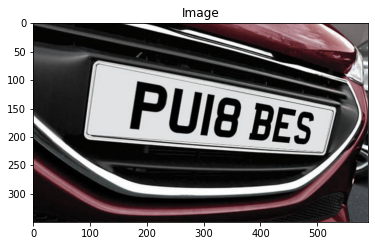

In [58]:
# Random image
random_index = rd.randint(0, len(raw_imgs) - 1)
print(f"Image: {random_index}")

image = raw_imgs[random_index]
image_gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
image_gray = np.float32(image_gray)

plt.figure()
plt.title("Image")
plt.imshow(image, cmap="gray")


Image shape: (213, 415, 3)
max value: 255.0


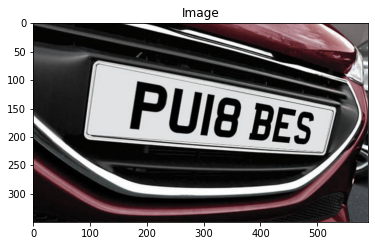

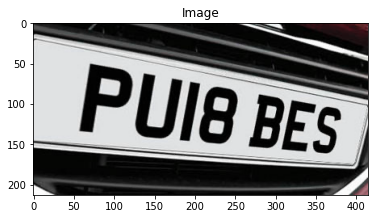

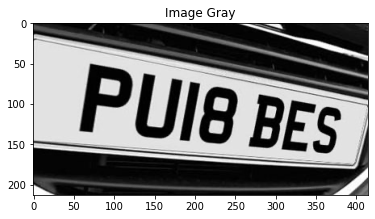

In [59]:

image = raw_imgs[random_index]
image_gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
image_gray = np.float32(image_gray)

plt.figure()
plt.title("Image")
plt.imshow(image, cmap="gray")

padding = 3
plate = annotations[random_index]
xmin = plate.xmin-padding
ymin = plate.ymin-padding
xmax = plate.xmax+padding
ymax = plate.ymax+padding
image_gray = image_gray[ymin:ymax, xmin:xmax]
image = image[ymin:ymax, xmin:xmax]

# Replicated borders
# top = int(0.05 * image_gray.shape[0])
# bottom = top
# left = int(0.05 * image_gray.shape[1])
# right = left
# image_gray = cv.copyMakeBorder(
#   image_gray,
#   top, bottom, left, right,
#   cv.BORDER_REPLICATE)
# image = cv.copyMakeBorder(
#   image,
#   top, bottom, left, right,
#   cv.BORDER_REPLICATE)

print(f"Image shape: {image.shape}")
print(f"max value: {np.max(image_gray)}")

plt.figure()
plt.title("Image")
plt.imshow(image, cmap="gray")
plt.figure()
plt.title("Image Gray")
plt.imshow(image_gray, cmap="gray")

## Classification of pixels based on color

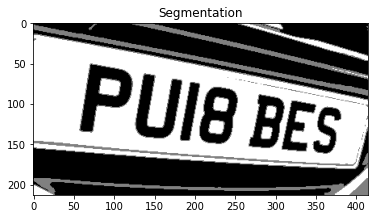

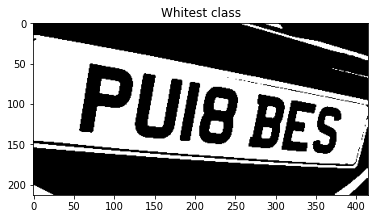

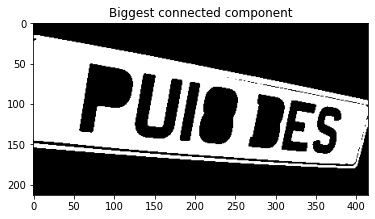

In [60]:

def kmean_segmentation(img, n_iterations = 5, n_classes = 10):
  # Initial classes centers
  max_val = np.max(img)
  min_val = np.min(img)
  interval = float(max_val-min_val)/n_classes
  classes_center = np.array([ interval/2 + min_val + interval*i for i in range(n_classes) ])

  classification = np.zeros(img.shape)
  classes_pixel_values = []
  for i in range(n_iterations):
    # Update pixel classes
    classes_pixel_values = [[] for i in range(n_classes)]
    for l in range(0, img.shape[0]):
      for c in range(0, img.shape[1]):
        dist_to_classes = np.abs(classes_center-img[l,c])
        class_index = np.argmin(dist_to_classes)
        classes_pixel_values[class_index].append(img[l,c])
        classification[l,c] = class_index

    # Update class centers
    for i in range(n_classes):
      center = np.mean(np.array(classes_pixel_values[i]))
      classes_center[i] = center

  return classification


# Smooth the image
image_blur = cv.GaussianBlur(image_gray, ksize=(3, 3), sigmaX=0)

# Classify based on color
# The brightess color is the last class
seg = kmean_segmentation(image_blur, 10, 3)

# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# K = 3
# Z = image.reshape((-1,3))
# Z = np.float32(Z)
# ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
# center = np.uint8(center)
# res = center[label.flatten()]
# seg = res.reshape((image.shape))

seg = np.uint8(seg)
plt.figure()
plt.title("Segmentation")
plt.imshow(seg, cmap="gray")

# Extract the class closest to white (The last class)
class0 = np.uint8(1*(seg==2))
# Extract connected components of that class
ret, comps = cv.connectedComponents(class0)
# Get the size of the components
colors, counts = np.unique(
  comps.reshape(-1), return_counts = True, axis = 0
  )
colors = np.delete(colors, 0) # Remove background component
counts = np.delete(counts, 0) # Remove background component
# Get the biggest component
compMax = comps==colors[np.argmax(counts)]
compMax = np.uint8(compMax)

plt.figure()
plt.title("Whitest class")
plt.imshow(class0, cmap='gray')

plt.figure()
plt.title("Biggest connected component")
# plt.imshow(comps==colors[np.argmax(counts)], cmap="gray")
plt.imshow(compMax, cmap="gray")

# We are left with a single connected 
# component that should be most parts of the plate
seg = compMax


[[-1.1475845e+01  1.5271036e+02]
 [ 5.5191040e-02  1.4337929e+01]
 [ 4.2055176e+02  4.9379303e+01]
 [ 4.0902069e+02  1.8775174e+02]]
A:: 1


/tmp/ipykernel_40237/278153365.py:25: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(255),2)


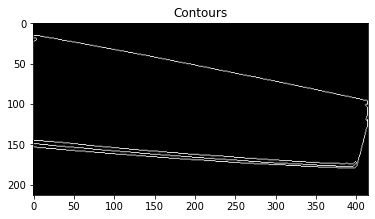

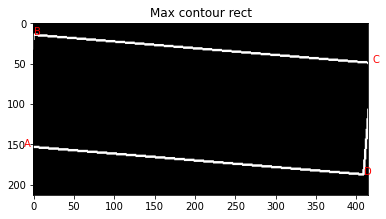

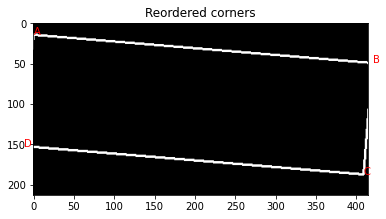

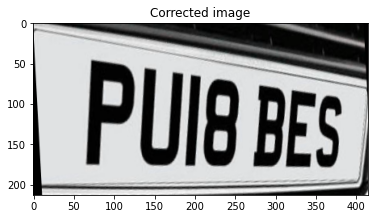

In [61]:

# Detect contours
contours, _= cv.findContours(
    seg, 
    mode=cv.RETR_EXTERNAL, # We should get a single contours for the single connected component
    method=cv.CHAIN_APPROX_SIMPLE
)
image_contours = np.zeros(image_gray.shape, dtype=np.uint8)
cv.drawContours(image_contours, contours=contours, contourIdx=-1, color=(255, 255, 255))
plt.figure()
plt.title("Contours")
plt.imshow(image_contours, cmap="gray")

# Find biggest contour
max_area_contour = contours[0]
max_area = cv.contourArea(max_area_contour)
for contour in contours:
  area = cv.contourArea(contour)
  if area > max_area:
    max_area = area
    max_area_contour = contour

image_polycontours_best = np.zeros(image_gray.shape, dtype=np.uint8)
rect = cv.minAreaRect(max_area_contour)
corners = cv.boxPoints(rect)
cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(255),2)
plt.figure()
plt.title("Max contour rect")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r")
plt.text(corners[1,0],corners[1,1], "B", c="r")
plt.text(corners[2,0],corners[2,1], "C", c="r")
plt.text(corners[3,0],corners[3,1], "D", c="r")
print(corners)

Aind = np.argmin(np.linalg.norm(corners-np.zeros(corners.shape), axis=1))
print(f"A:: {Aind}")
corners = np.array([ corners[(i+Aind)%4] for i in range(4)])
plt.figure()
plt.title("Reordered corners")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r")
plt.text(corners[1,0],corners[1,1], "B", c="r")
plt.text(corners[2,0],corners[2,1], "C", c="r")
plt.text(corners[3,0],corners[3,1], "D", c="r")

out_height = image.shape[0]
out_width = image.shape[1]
output_size = (out_width, out_height)
perspective_matrix = cv.getPerspectiveTransform(
  corners,
  np.array([
      [0, 0], [out_width, 0],
      [out_width, out_height], [0, out_height]
    ], dtype=np.float32)
  )
corrected_image = cv.warpPerspective(
  image, perspective_matrix, output_size, cv.WARP_INVERSE_MAP
  )

plt.figure()
plt.title("Corrected image")
plt.imshow(corrected_image, cmap="gray")


## Complete pipeline test

In [64]:

def getUnwarpedPlate(imageRGB, plate_xmin, plate_ymin, plate_xmax, plate_ymax):
  image = np.copy(imageRGB)
  image_gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
  image_gray = np.float32(image_gray)
  padding = 1
  xmin = plate_xmin-padding
  ymin = plate_ymin-padding
  xmax = plate_xmax+padding
  ymax = plate_ymax+padding
  image_gray = image_gray[ymin:ymax, xmin:xmax]
  image = image[ymin:ymax, xmin:xmax]

  # Smooth the image
  image_blur = cv.GaussianBlur(image_gray, ksize=(3, 3), sigmaX=0)
  # Classify based on color
  # The brightess color is the last class
  seg = kmean_segmentation(image_blur, 10, 3)
  seg = np.uint8(seg)
  # Extract the class closest to white (The last class)
  class0 = np.uint8(1*(seg==2))
  # Extract connected components of that class
  ret, comps = cv.connectedComponents(class0)
  # Get the size of the components
  colors, counts = np.unique(
    comps.reshape(-1), return_counts = True, axis = 0
    )
  colors = np.delete(colors, 0) # Remove background component
  counts = np.delete(counts, 0) # Remove background component
  # Get the biggest component
  compMax = comps==colors[np.argmax(counts)]
  compMax = np.uint8(compMax)
  # We are left with a single connected 
  # component that should be most parts of the plate

  # We extract the contours of the component
  contours, _= cv.findContours(
      compMax, 
      mode=cv.RETR_EXTERNAL, # We should get a single contours for the single connected component
      method=cv.CHAIN_APPROX_SIMPLE
  )
  # We get the oriented bounding box
  rect = cv.minAreaRect(contours[0])
  corners = cv.boxPoints(rect)
  # We reorder the bounding box corners  
  Aind = np.argmin(np.linalg.norm(corners-np.zeros(corners.shape), axis=1))
  corners = np.array([ corners[(i+Aind)%4] for i in range(4)])

  # We apply perspective correction
  out_height = image.shape[0]
  out_width = image.shape[1]
  output_size = (out_width, out_height)
  perspective_matrix = cv.getPerspectiveTransform(
    corners,
    np.array([
        [0, 0], [out_width, 0],
        [out_width, out_height], [0, out_height]
      ], dtype=np.float32)
    )
  corrected_image = cv.warpPerspective(
    image, perspective_matrix, output_size, cv.WARP_INVERSE_MAP
    )
  return corrected_image


image 213: 1.5849428176879883 seconds
image 90: 0.11127853393554688 seconds
image 226: 0.524895191192627 seconds
image 21: 0.06548070907592773 seconds
image 86: 0.8438558578491211 seconds
image 392: 0.09508776664733887 seconds
image 363: 0.28136634826660156 seconds
image 360: 0.5124366283416748 seconds
image 83: 1.3006043434143066 seconds
image 84: 0.6072666645050049 seconds
image 207: 0.4551889896392822 seconds
image 87: 0.08500242233276367 seconds
image 207: 0.4802720546722412 seconds
image 402: 1.4186856746673584 seconds
image 34: 0.09041142463684082 seconds
image 200: 7.871097087860107 seconds
image 61: 0.09158849716186523 seconds
image 354: 0.17584228515625 seconds
image 131: 0.5834934711456299 seconds
image 325: 0.2996640205383301 seconds


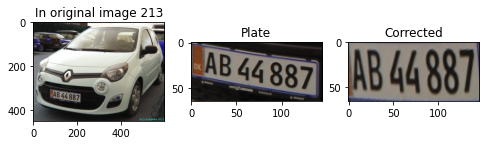

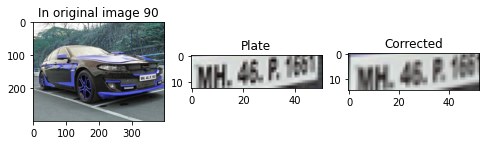

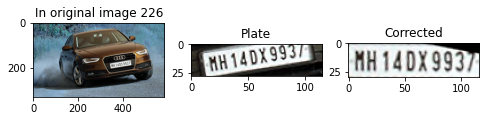

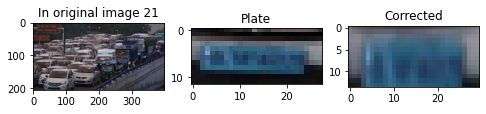

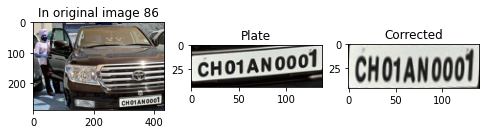

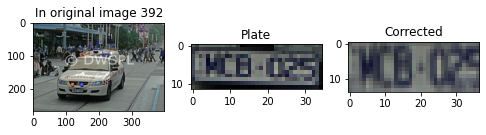

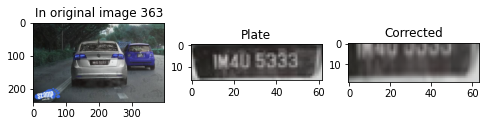

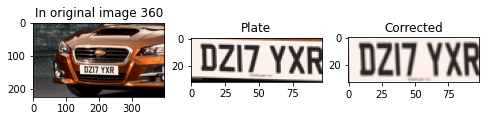

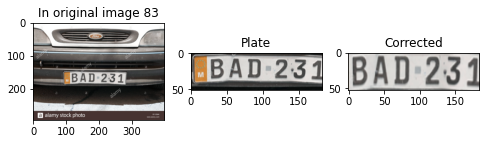

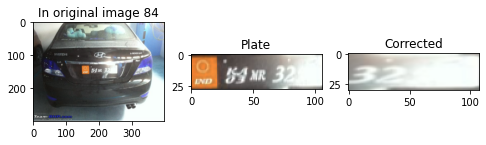

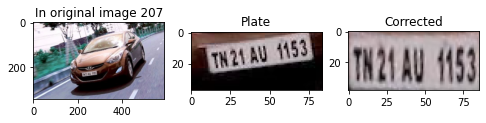

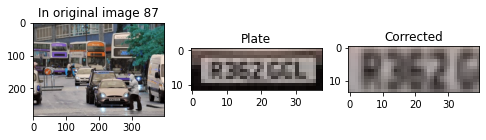

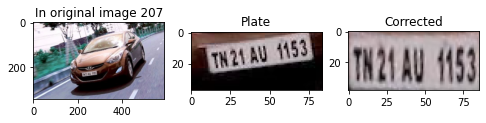

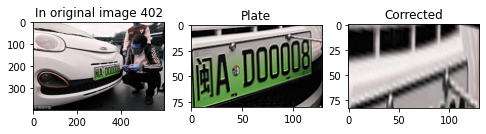

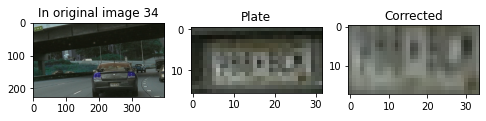

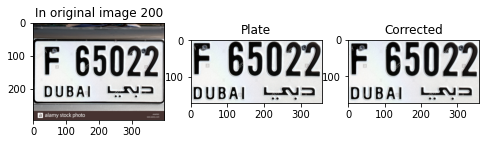

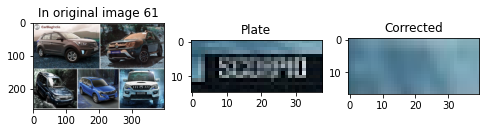

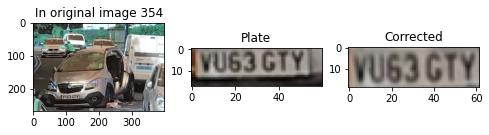

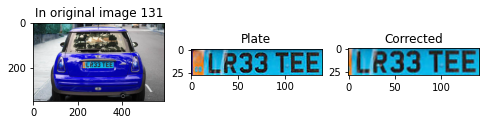

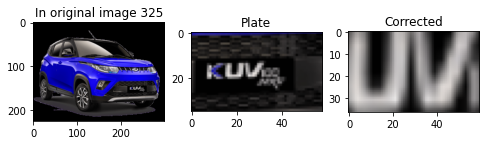

In [65]:
image_indices = rd.choices(np.arange(len(raw_imgs)), k=20)
uncorrected_images = []
corrected_images = []
anno_images = []
for index in image_indices:
  start = time.time()

  wholeimage = raw_imgs[index]
  plate = annotations[index]
  corrected = getUnwarpedPlate(wholeimage, plate.xmin, plate.ymin, plate.xmax, plate.ymax)

  end = time.time()
  elapsed = end - start
  print(f"image {index}: {elapsed} seconds")

  corrected_images.append(corrected)
  uncorrected_images.append(wholeimage)
  anno_images.append(plate)

for i in range(len(corrected_images)):
  plate = anno_images[i]
  fig, axisarray = plt.subplots(1, 3, figsize=(8,8))
  axisarray[0].set_title(f"In original image {image_indices[i]}")
  axisarray[0].imshow(uncorrected_images[i])
  axisarray[1].set_title('Plate')
  axisarray[1].imshow(uncorrected_images[i][plate.ymin:plate.ymax, plate.xmin:plate.xmax])
  axisarray[2].set_title('Corrected')
  axisarray[2].imshow(corrected_images[i])
